In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import imageio as ig

In [2]:
with open('/home/dl4/Task2/All_good_frames_RGB_416.pkl', 'rb') as f:
    img_dict = pickle.load(f)
    frames = img_dict["frames"]

In [3]:
frames = np.array(frames)
frames.shape

(42123, 416, 416, 3)

In [6]:
frames[150].shape

(416, 416, 3)

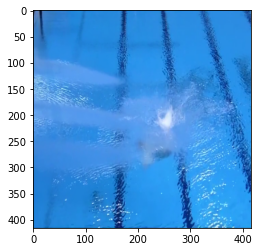

In [177]:
net = cv2.dnn.readNet('yolov4.weights', 'yolov4.cfg')    # yolo Modell laden



classes = ["splash"]
#display_img = cv2.imread('/home/dl4/Task2/Video_Frames/_8Vy3dlHg2w_00132/86.jpg') # Bild zur Visualisierung (BB aufzeigen, Confidence, etc...)
#display_img = cv2.imread('/home/dl4/Task2/Video_Frames/_tigfCJFLZg_00166/98.jpg') # Bild zur Visualisierung (BB aufzeigen, Confidence, etc...)
#display_img = cv2.imread('/home/dl4/Task2/Video_Frames/_lmT4WlK7G0_00000/150.jpg') # Bild zur Visualisierung (BB aufzeigen, Confidence, etc...)

#print(display_img.shape)

display_img = frames[20000]

#display_img = cv2.imread(hallo) # Bild zur Visualisierung (BB aufzeigen, Confidence, etc...)

img = display_img.copy() #unbearbeitetes Bild um Analyse durchzuführen (z.B: Masken)

display_img = cv2.cvtColor(display_img, cv2.COLOR_RGB2BGR)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

img1 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(img1)
plt.show()

height, width, _ = img.shape

blob = cv2.dnn.blobFromImage(display_img, 1/255, (416, 416), (0,0,0), swapRB=True, crop=False)
height, width, _ = img.shape


net.setInput(blob)

output_layers_names = net.getUnconnectedOutLayersNames()
layerOutputs = net.forward(output_layers_names)

boxes = []
confidences = []
class_ids = []


color = [0, 0, 255]

bb_size = 0 # Größe der Boundingbox


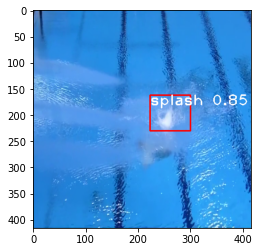

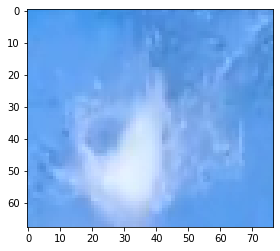

BB width:	77
BB height:	68


(68, 77, 3)

In [189]:
for output in layerOutputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0]*width)
            center_y = int(detection[1]*height)
            w = int(detection[2]*width)
            h = int(detection[3]*height)

            x = int(center_x - w/2)
            y = int(center_y - h/2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4) #Non Max Supression

font = cv2.FONT_HERSHEY_PLAIN


if len(indexes) > 0:
    for i in indexes.flatten():
        x, y, w, h = boxes[i]
        
        x, y, w, h = max(x, 0), max(y, 0), min(w, w + x), min(h, h + y) # für den Fall dass BB über dem Frame hinausgehen
        crop_img = img[y: y + h, x: x + w, :] # BB wird aus dem Frame ausgeschnitten und in eine Variable zum Feature Matching gespeichert
        
        bb_size = round(math.sqrt(w*h),2)
        
        label = str(classes[class_ids[i]])
        confidence = str(round(confidences[i], 2))
        cv2.rectangle(display_img, (x,y), (x+w, y+h), color, 2)
        cv2.putText(display_img, label + " " + confidence, (x, y+20), font, 2, (255,255,255), 2)

        
display_img1 = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)        
crop_img1 = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
        
plt.imshow(display_img1)
plt.show()
plt.imshow(crop_img1)
plt.show()

print("BB width:\t" + str(w))
print("BB height:\t" + str(h))


crop_img.shape

#print(bb_size)


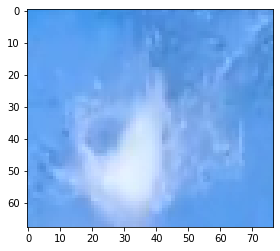

In [190]:
crop_1 = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
plt.imshow(crop_1)
plt.show()

hsv_crop = cv2.cvtColor(crop_1, cv2.COLOR_RGB2HSV)


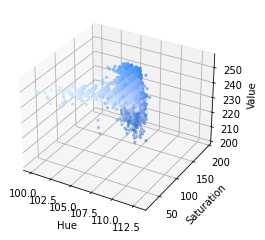

In [191]:
#Ausgabe von 3D Scatterbox --> für bessere Farberkennung
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
pixel_colors = crop_1.reshape((np.shape(crop_1)[0]*np.shape(crop_1)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()
h, s, v = cv2.split(hsv_crop)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

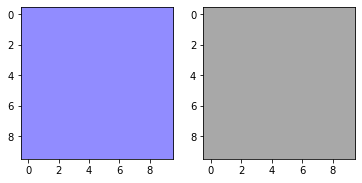

In [192]:
#Den Range festlegen für maske 
light_white = (0,0,168)
dark_white = (172,115,255)
# light_white = (0,0,168)
# dark_white = (172,150,255)
# light_white = (0,0,168)
# dark_white = (172,20,255)

from matplotlib.colors import hsv_to_rgb

lo_square = np.full((10, 10, 3), light_white, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_white, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

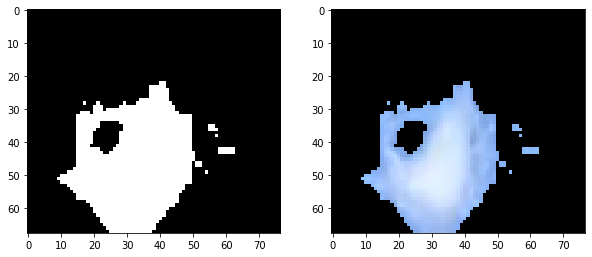

In [193]:
#Ausgabe des Frames mit Maske
mask = cv2.inRange(hsv_crop, light_white, dark_white)
result = cv2.bitwise_and(crop_1, crop_1, mask=mask)
plt.figure(figsize=(10,15))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

In [195]:
#Ausgabe von Pixelanzahl
print("Splash Volume: "+str(np.count_nonzero(mask)))


Splash Volume: 1200
